# 1. Environment Setup


In [1]:
import json
import torch
import numpy as np
import torch.nn as nn
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from pathlib import Path
from types import SimpleNamespace
from importlib import import_module

%matplotlib inline

In [2]:
from senn.models.losses import *
from senn.models.parameterizers import *
from senn.models.conceptizers import *
from senn.models.aggregators import *
from senn.models.senn import SENN, DiSENN

In [3]:
from senn.datasets.dataloaders import get_dataloader
from senn.utils.plot_utils import show_explainations, show_prototypes, plot_lambda_accuracy, get_comparison_plot

In [4]:
from rotation import rotate_resize_and_cast, rotate_image

## Utility functions

In [5]:
def get_config(filename):
    config_path = Path('configs')
    config_file = config_path / filename
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    return SimpleNamespace(**config)

In [6]:
def load_checkpoint(config):
    model_file = Path('results') / config.exp_name / "checkpoints" / "best_model.pt" 
    return torch.load(model_file, config.device)

In [7]:
def accuracy(model, dataloader, config):
    accuracies = []
    model.eval()
    with torch.no_grad():
        for i, (x, labels) in enumerate(dataloader):
            x = x.float().to(config.device)
            labels = labels.long().to(config.device)
            y_pred, (concepts, relevances), _ = model(x)
            accuracies.append((y_pred.argmax(axis=1) == labels).float().mean().item())
    accuracy = np.array(accuracies).mean()
    print(f"Test Mean Accuracy: {accuracy * 100: .3f} %")

## Config

In [8]:
plt.style.use('seaborn-v0_8-paper')

# 2. Basic Comparisons

In [9]:
mnist_config = get_config("mnist_lambda1e-4_seed29.json")
mnist_config.device = "cpu"

In [10]:
_, _, mnist_test_dl = get_dataloader(mnist_config)

In [11]:
conceptizer = ConvConceptizer(**mnist_config.__dict__)
parameterizer = ConvParameterizer(**mnist_config.__dict__)
aggregator = SumAggregator(**mnist_config.__dict__)

mnist_SENN = SENN(conceptizer, parameterizer, aggregator)

In [12]:
mnist_checkpoint = load_checkpoint(mnist_config)
mnist_SENN.load_state_dict(mnist_checkpoint['model_state'])

/var/folders/7s/51n924ds2p15l54wx1p9dwm80000gn/T/ipykernel_4579/3168636641.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_file, config.device)


<All keys matched successfully>

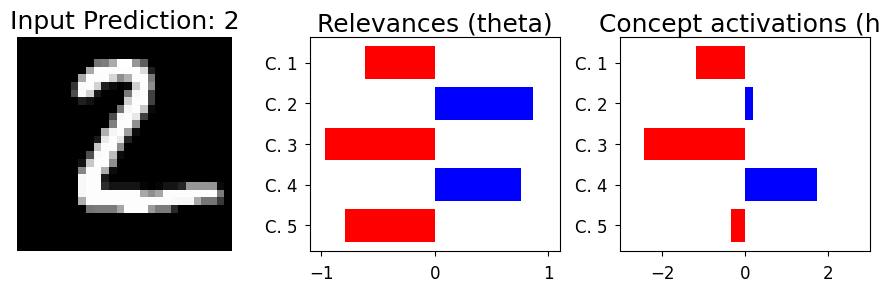

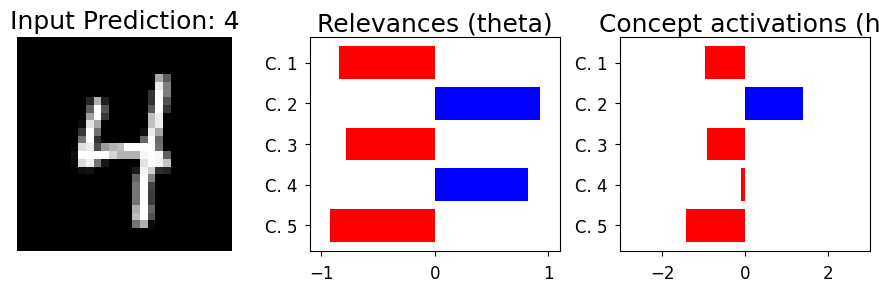

In [13]:
show_explainations(mnist_SENN, mnist_test_dl, 'mnist')